In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear  
# inline in the notebook rather than in a new window.
%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# import the necessary packages
import cv2
import os
import glob

# OpenCV Contours

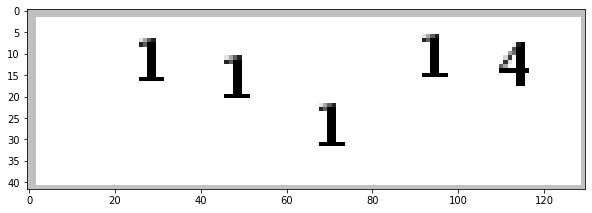

In [2]:
imagePath = './datasets/breaking-captcha/solved-captchas/11114.png'
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

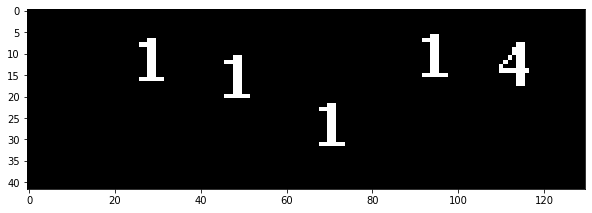

In [3]:
# threshold the image to reveal the digits
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow(thresh)

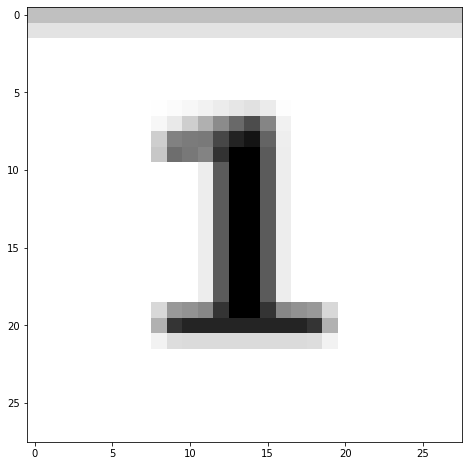

In [4]:
_, cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
(x, y, w, h) = cv2.boundingRect(cnts[-1])
roi = gray[y - 5:y + h + 5, x - 5:x + w + 5]
plt.imshow(cv2.resize(roi, (28, 28)))

# Annotate

In [5]:
input = './datasets/breaking-captcha'
output = './output/breaking-captcha'

# grab the image paths then initialize the dictionary of character counts
imagePaths = glob.glob('./datasets/breaking-captcha/solved-captchas/*.png', recursive=True)
counts = {}

[INFO] processing image 1/938


TypeError: 'str' object is not callable

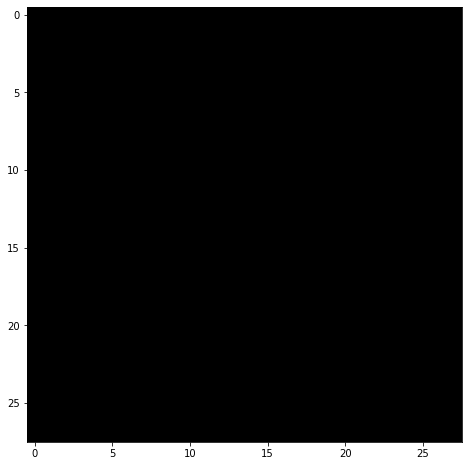

In [6]:
# loop over the image paths
for(i, imagePath) in enumerate(imagePaths):
    # display an update to the user
    print("[INFO] processing image {}/{}".format(i + 1, len(imagePaths)))
    
    try:
        # load the image and convert it to grayscale, then pad the
        # image to ensure digits caught on the border of the image
        # are retained
        image = cv2.imread(imagePath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
        
        # threshold the image to reveal the digits
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        
        # find contours in the image, keeping only the four largest ones
        _, cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        # loop over the contours
        for c in cnts:
            # compute the bounding box for the contour then extract the digit
            (x, y, w, h) = cv2.boundingRect(c)
            roi = gray[y - 5:y + h + 5, x - 5:x + w + 5]
            
            # display the character, making it larger enough for us
            # to see, then wait for a keypress
            plt.imshow(cv2.resize(roi, (28, 28)))
            key = input('input a number')
            
            # if the ’‘’ key is pressed, then ignore the character
            if key == ord("‘"):
                print("[INFO] ignoring character")
                continue
    
            # grab the key that was pressed and construct the path
            # the output directory
            key = chr(key).upper()
            dirPath = os.path.sep.join(output, key)
    
            # if the output directory does not exist, create it
            if not os.path.exists(dirPath):
                os.makedirs(dirPath)
    
            # write the labeled character to file
            count = counts.get(key, 1)
            p = os.path.sep.join([dirPath, "{}.png".format(str(count).zfill(6))])
            cv2.imwrite(p, roi)
    
            # increment the count for the current key
            counts[key] = count + 1
    
    # we are trying to control-c out of the script, so break from the
    # loop (you still need to press a key for the active window to
    # trigger this)
    except KeyboardInterrupt:
        print("[INFO] manually leaving script")
        break